In [129]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import numpy as np
import yaml
import pandas as pd
import random

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
#カスタム評価関数
#Pickleでは保存できなかったので、別にしたがそれでもModelの保存はできなかった
from f1_score_metric import F1ScoreMacro

import optuna

import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch import nn
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.metrics import f1_score

In [130]:
def createfeatures(data,cat_feature):
    templist=['NoEmp','CreateJob','RetainedJob','DisbursementGross','GrAppv','SBA_Appv']
    
    for col in templist:
        means = data.groupby(cat_feature)[col].mean()
        # 各ローンのTermとセクター平均Termとの差を計算
        data[f'{col}_Diff_{cat_feature}_Mean'] = data.apply(lambda x: x[col] - means[x[cat_feature]], axis=1)

        # 各ローンのTermとセクター平均Termとの比を計算
        data[f'{col}_Ratio_{cat_feature}_Mean'] = data.apply(lambda x: x[col] / means[x[cat_feature]], axis=1)
        
    return data

In [131]:
file_path = '../config/config.yaml'

# ファイルを開いて内容を読み込む
with open(file_path, 'r', encoding='utf-8') as file:
    yaml = yaml.safe_load(file)

# featuresリストを取得
features = yaml.get('features', [])

data = [pd.read_pickle(f"../features/{f}.pkl") for f in features]
data = pd.concat(data, axis=1)

In [132]:
# data=pd.read_pickle('../features/base_data.pkl')

In [133]:
# Handle possible division by zero
data.replace([np.inf, -np.inf], np.nan, inplace=True)
# 各行の欠損値の数を計算
data['missing_values_count'] = data.isna().sum(axis=1)
# for col in ['State','Sector','FranchiseCode']:
#     data = createfeatures(data,col)

In [134]:
state_to_coords = {
    'AL': (32.806671, -86.791130), 'AK': (61.370716, -152.404419), 'AZ': (33.729759, -111.431221),
    'AR': (34.969704, -92.373123), 'CA': (36.116203, -119.681564), 'CO': (39.059811, -105.311104),
    'CT': (41.597782, -72.755371), 'DE': (39.318523, -75.507141), 'FL': (27.766279, -81.686783),
    'GA': (33.040619, -83.643074), 'HI': (21.094318, -157.498337), 'ID': (44.240459, -114.478828),
    'IL': (40.349457, -88.986137), 'IN': (39.849426, -86.258278), 'IA': (42.011539, -93.210526),
    'KS': (38.526600, -96.726486), 'KY': (37.668140, -84.670067), 'LA': (31.169546, -91.867805),
    'ME': (44.693947, -69.381927), 'MD': (39.063946, -76.802101), 'MA': (42.230171, -71.530106),
    'MI': (43.326618, -84.536095), 'MN': (45.694454, -93.900192), 'MS': (32.741646, -89.678696),
    'MO': (38.456085, -92.288368), 'MT': (46.921925, -110.454353), 'NE': (41.125370, -98.268082),
    'NV': (38.313515, -117.055374), 'NH': (43.452492, -71.563896), 'NJ': (40.298904, -74.521011),
    'NM': (34.840515, -106.248482), 'NY': (42.165726, -74.948051), 'NC': (35.630066, -79.806419),
    'ND': (47.528912, -99.784012), 'OH': (40.388783, -82.764915), 'OK': (35.565342, -96.928917),
    'OR': (44.572021, -122.070938), 'PA': (40.590752, -77.209755), 'RI': (41.680893, -71.511780),
    'SC': (33.856892, -80.945007), 'SD': (44.299782, -99.438828), 'TN': (35.747845, -86.692345),
    'TX': (31.054487, -97.563461), 'UT': (40.150032, -111.862434), 'VT': (44.045876, -72.710686),
    'VA': (37.769337, -78.169968), 'WA': (47.400902, -121.490494), 'WV': (38.491226, -80.954570),
    'WI': (44.268543, -89.616508), 'WY': (42.755966, -107.302490)
}

# Apply the mapping to the dataset to create new latitude and longitude columns
data['Latitude'] = data['State'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['Longitude'] = data['State'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)
data['BankState_Latitude'] = data['BankState'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['BankState_Longitude'] = data['BankState'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)

In [135]:
train = data[data["train"]==True].drop(columns="train")
test = data[data['train'] == False]
test = test.drop(['train','MIS_Status'],axis=1)

In [136]:
# 訓練データの読み込み
X_train = train[['Term']]

# スケーラーの初期化と適用（訓練データに対して）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# クラスタ数の候補を設定
n_components = np.arange(1, 10)

# BICを格納するためのリスト
bics = []

# 各クラスタ数に対してGMMをフィットし、BICを計算
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(X_train_scaled)
    bics.append(gmm.bic(X_train_scaled))

# クラスタ数を選定
gmm = GaussianMixture(n_components=7, random_state=0)
gmm.fit(X_train_scaled)

# 各データポイントのクラスタ割り当てを取得
cluster_assignments = gmm.predict(X_train_scaled)

# クラスタ割り当て結果をデータフレームに追加
train['Term_Cluster'] = cluster_assignments

# テストデータの読み込みとスケーリング（訓練データでフィットしたスケーラーを使用）
X_test = test[['Term']]
X_test_scaled = scaler.transform(X_test)

# 訓練データでフィットさせたGMMを使用してクラスタ割り当てを予測
test['Term_Cluster'] = gmm.predict(X_test_scaled)

In [137]:
train['Term_Cluster'].unique()

array([3, 5, 1, 0, 2, 4, 6], dtype=int64)

In [138]:
test['Term_Cluster'].unique()

array([2, 1, 6, 0, 5, 3, 4], dtype=int64)

In [139]:
# trainとtestのカラムをセットとして取得
train_columns = set(train.columns)
test_columns = set(test.columns)

# trainにのみ存在するカラムを見つける
train_unique = train_columns - test_columns

# testにのみ存在するカラムを見つける
test_unique = test_columns - train_columns

# 結果を表示
print("Train unique columns:", train_unique)
print("Test unique columns:", test_unique)

Train unique columns: {'MIS_Status'}
Test unique columns: set()


In [140]:

lgb_train = pd.read_csv('../data/train_lgb_predictions3.csv')
lgb_test = pd.read_csv('../data/test_lgb_predictions3.csv')

cb_train = pd.read_csv('../data/train_cb_predictions.csv')
cb_test = pd.read_csv('../data/test_cb_predictions.csv')

# # rf_train = pd.read_csv('../data/Stacking/rf/train_rf_predictions.csv')
# # rf_test = pd.read_csv('../data/Stacking/rf/test_rf_predictions.csv')

from functools import reduce

train = reduce(lambda left, right: pd.merge(left, right, on='ID'), [train, lgb_train,cb_train])

test = reduce(lambda left, right: pd.merge(left, right, on='ID'), [test, lgb_test,cb_test])

In [141]:
fixlist = ['DisbursementGross','GrAppv','SBA_Appv']

for col in fixlist:
    x = data[col] + 1
    data[col] = np.log(x)

In [142]:
X_train = train.drop('MIS_Status', axis=1)
y_train = train['MIS_Status']

In [143]:
category_features = ['City','State','BankState', 'Sector',  'NewExist','UrbanRural','RevLineCr', 'LowDoc','FranchiseFlag','IsSameState','Term_Cluster']

all_features = X_train.columns.tolist()
col_num = [feature for feature in all_features if feature not in category_features]
col_num = [feature for feature in col_num if feature != 'MIS_Status']
col_num = [feature for feature in col_num if feature != 'train']
col_num = [feature for feature in col_num if feature != 'ID']
for item in category_features:
    X_train[item] = X_train[item].astype('object')

In [144]:
low_cat_cols = [] # nunique が少ない変数
high_cat_cols = [] # nunique が多い変数

for c in category_features:
    nunq = X_train[c].nunique()
    if nunq>1:
        high_cat_cols.append(c)
    else:
        low_cat_cols.append(c)

In [145]:
#nunique数が少ない変数
dict_low_cat = {}
for col in low_cat_cols:
    print(col)
    value_fillna = 'unknown'
    X_train[col] = X_train[col].fillna(value_fillna)
    X_train[col] = X_train[col].astype(str)
    
    dict_low_cat[col] = {}
    dict_low_cat[col]['fillna'] = value_fillna
    
X_train = pd.get_dummies(X_train, dummy_na=False, drop_first=False, columns=low_cat_cols)
print('Done')

FranchiseFlag
Done


In [146]:
dict_high_cat = {}
for col in high_cat_cols:
    print(col)
    value_fillna = 'unknown'
    X_train[col] = X_train[col].fillna(value_fillna)
    X_train[col] = X_train[col].astype(str)
    # strに変換
    le = LabelEncoder()
    le.fit(X_train[col])
    list_label = sorted(list(set(le.classes_) | set(['unknown'])))
    # print(list_label)
    map_label = {j:i for i,j in enumerate(list_label)}
    X_train[col] = X_train[col].map(map_label)
    # categorical_dims = len(le.classes_)

    
    dict_high_cat[col] = {}
    dict_high_cat[col]['fillna'] = value_fillna
    dict_high_cat[col]['map_label'] = map_label
    dict_high_cat[col]['num_label'] = len(list_label)
    

print('Done')

City
State
BankState
Sector
NewExist
UrbanRural
RevLineCr
LowDoc
IsSameState
Term_Cluster
Done


In [147]:

dict_num = {}

for col in col_num:
    print(col)
    # 欠損値を0へ
    value_fillna = 0 
    X_train[col] = X_train[col].fillna(value_fillna)
    # 正規化または標準化
    value_min = X_train[col].min()
    value_max = X_train[col].max()
    value_mean = X_train[col].mean()
    value_std = X_train[col].std()
    #train[col] = (train[col] - value_min) / (value_max - value_min)
    X_train[col] = (X_train[col] - value_mean) / value_std
    
    dict_num[col] = {}
    dict_num[col]['fillna'] = value_fillna
    dict_num[col]['min'] = value_min
    dict_num[col]['max'] = value_max
    dict_num[col]['mean'] = value_mean    
    dict_num[col]['std'] = value_std    
    
print('Done')

Term
NoEmp
CreateJob
RetainedJob
FranchiseCode
ApprovalFY
DisbursementGross
GrAppv
SBA_Appv
NewBusiness
DisbursementYear
DisbursementMonth
DisbursementDay
ApprovalMonth
ApprovalDay
LoanProcessingPeriod
LoanvsApprovedAmountDifference
SBAGuaranteeRatio
YearsSinceApproval
Jobs_Created_per_Employee
Jobs_Retained_per_Employee
Loan_Amount_per_Employee
BankStateCount
CityCount
SectorCount
StateCount
LoanToValueRatio
RealEstate
GreatRecession
AppvDisbursed
missing_values_count
Latitude
Longitude
BankState_Latitude
BankState_Longitude
lgb_preds
catboost_preds
Done


In [148]:
for item in category_features:
    test[item] = test[item].astype('object')

In [149]:
# テストデータに対しての処理を関数化
def transform_data(input_x):
    output_x = input_x.copy()
    
    for col in col_num:
        value_fillna = dict_num[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        value_min = dict_num[col]['min']
        value_max = dict_num[col]['max']
        value_mean = dict_num[col]['mean']
        value_std = dict_num[col]['std']
        
        # output_x[col]  = (output_x[col] - value_min ) / (value_max - value_min)
        output_x[col]  = (output_x[col] - value_mean ) / (value_std)
        
        
    for col in low_cat_cols:
        value_fillna = dict_low_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
    for col in high_cat_cols:
        value_fillna = dict_high_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_label = dict_high_cat[col]['map_label']
        output_x[col] = output_x[col].map(map_label)
        
        #対応するものがない場合はunkoumn
        output_x[col] = output_x[col].fillna(map_label['unknown'])
        
    output_x = pd.get_dummies(output_x, dummy_na=False, drop_first=False, columns=low_cat_cols)
        
    return output_x

x_test = transform_data(test)

In [150]:
print('学習用データ: {},  学習ラベル：{}, テストデータ：{}'.format(
    X_train.shape, y_train.shape,  x_test.shape))

print('陽性ラベルの割合: {}'.format(
    y_train.value_counts()[1]  / len(train)))

学習用データ: (42307, 49),  学習ラベル：(42307,), テストデータ：(42308, 49)
陽性ラベルの割合: 0.8926891530952324


In [151]:
from torch.nn import CrossEntropyLoss
#不均衡データ用の重み
from sklearn.utils import class_weight

class_weights = list(class_weight.compute_class_weight('balanced', 
                                                        classes=np.unique(y_train),
                                                        y=y_train)
                        )
weights = torch.from_numpy(np.array(class_weights)).float()

# lossを指定し重みを加える 重み無しならLossはNone
cross_entropy_loss_wight = CrossEntropyLoss(weight=weights)

In [152]:
cat_idxs = [ i for i, f in enumerate(X_train) if f in high_cat_cols]# 特徴量の中のembeddingしたい番号
cat_dims = [dict_high_cat[i]['num_label'] for i in high_cat_cols]# embeddingしたい特徴量のlabel数

In [153]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    # cat_idxs=cat_idxs,
    # cat_dims=cat_dims,
    # cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

In [154]:
# idを別のdfに、
id_train = X_train[['ID']]
X_train = X_train.drop(['ID'], axis=1)

id_test = x_test[id_train.columns]
x_test = x_test.drop(['ID'], axis=1)

In [155]:
random_state = 810

x_tr, x_va, y_tr, y_va = train_test_split(X_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
y_tr=np.squeeze(y_tr.values)
y_va=np.squeeze(y_va.values)
x_tr=x_tr.values
x_va=x_va.values

print('訓練データ: ',x_tr.shape, y_tr.shape)
print('検証データ: ',x_va.shape, y_va.shape)

訓練データ:  (33845, 48) (33845,)
検証データ:  (8462, 48) (8462,)


In [156]:
unsupervised_model.fit(
    X_train=x_tr,
    eval_set=[x_va],
    max_epochs=100, 
    patience=5,
    batch_size=2048, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

epoch 0  | loss: 2.46071 | val_0_unsup_loss_numpy: 1.9629700183868408|  0:00:01s
epoch 5  | loss: 1.03553 | val_0_unsup_loss_numpy: 0.9850500226020813|  0:00:09s
epoch 10 | loss: 0.93424 | val_0_unsup_loss_numpy: 0.8598399758338928|  0:00:18s
epoch 15 | loss: 0.9138  | val_0_unsup_loss_numpy: 0.8046799898147583|  0:00:26s
epoch 20 | loss: 0.87653 | val_0_unsup_loss_numpy: 0.7666900157928467|  0:00:34s
epoch 25 | loss: 0.85212 | val_0_unsup_loss_numpy: 0.7416599988937378|  0:00:42s
epoch 30 | loss: 0.84285 | val_0_unsup_loss_numpy: 0.7135699987411499|  0:00:51s
epoch 35 | loss: 0.82771 | val_0_unsup_loss_numpy: 0.7014200091362|  0:01:01s
epoch 40 | loss: 0.81364 | val_0_unsup_loss_numpy: 0.693560004234314|  0:01:09s
epoch 45 | loss: 0.80594 | val_0_unsup_loss_numpy: 0.6843900084495544|  0:01:17s
epoch 50 | loss: 0.79304 | val_0_unsup_loss_numpy: 0.6754999756813049|  0:01:26s
epoch 55 | loss: 0.78557 | val_0_unsup_loss_numpy: 0.6685299873352051|  0:01:36s
epoch 60 | loss: 0.77433 | val_0

In [157]:
# 保存して使い回す
unsupervised_model.save_model('./model/tabnet/pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./model/tabnet/pretrain.zip')

Successfully saved model at ./model/tabnet/pretrain.zip


In [158]:
# import torch
# import pandas as pd

# def objective(trial):
#     mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
#     n_da = trial.suggest_int("n_da", 8, 64, step=8)
#     n_steps = trial.suggest_int("n_steps", 1, 10, step=3)
#     gamma = trial.suggest_float("gamma", 1.0, 2.0, step=0.2)
#     n_shared = trial.suggest_int("n_shared", 1, 3)
#     lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)

#     tabnet_params = dict(
#         n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
#         lambda_sparse=lambda_sparse, mask_type=mask_type, n_shared=n_shared,
#         optimizer_fn=torch.optim.Adam,
#         optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
#         scheduler_params=dict(
#             mode="min", patience=10,
#             scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
#             verbose=0,
#         )
#     )

#     model = TabNetClassifier(**tabnet_params)
#     model.fit(
#         X_train=x_tr, y_train=y_tr,
#         eval_set=[(x_va, y_va)],
#         patience=15,
#         max_epochs=100,
#         eval_metric=[F1ScoreMacro]
#     )
    
    
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # 最適なパラメータを表示
# print(study.best_params)

In [159]:
random_state = 123
params = {
            'n_d': 32, #値が大きいほど表現力と過学習のリスクがあがる
            'n_a': 32, # n_dと同じ値にしておくのが良いらしい
            'n_steps': 2,#TabNetEncoderのstepを何回繰り返すか
            'gamma': 1.0,
            'n_independent': 2,
            'n_shared': 2,
            'seed':random_state,
            'lambda_sparse': 1.6947238775293536e-06,
            'optimizer_fn': torch.optim.Adam, 
            'optimizer_params': {'lr':2e-2},
            'mask_type': 'sparsemax',#AttentiveTransformerでマスク作るのにどっちの関数を使うか'sparsemax'or'entmax'
            'scheduler_params':{'mode': "min",'patience': 5,'min_lr': 1e-5,'factor': 0.9},
            'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
            'cat_idxs':cat_idxs,
            'cat_dims':cat_dims,
            'cat_emb_dim':3,
            'verbose':10
        }

In [160]:


# cvでの評価用
def train_tabnet(
    input_x,
    input_y,
    input_id,
    params,
    list_nfold=[0,1,2,3,4],
    n_splits=5,
    random_state=123
            ):
    # foldごとの推論値保存用
    train_oof = np.zeros(len(input_x))
    metrics = []
    imp = pd.DataFrame()

    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).split(input_x, input_y ))
    for  nfold in list_nfold :
        print('-'*20, nfold, '-'*20)
        
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.iloc[idx_tr], input_y.iloc[idx_tr]
        x_va, y_va = input_x.iloc[idx_va], input_y.iloc[idx_va]
        
        y_tr=np.squeeze(y_tr.values)
        y_va=np.squeeze(y_va.values)
        x_tr=x_tr.values
        x_va=x_va.values
        
        model = TabNetClassifier(**params)
        model.fit(
            X_train=x_tr,
            y_train=y_tr,
            eval_set=[(x_va, y_va)],
            eval_name = ["valid"],
            eval_metric = [F1ScoreMacro],
            loss_fn = cross_entropy_loss_wight,#重み付きのloss,重みが不要ならNoneで
            max_epochs=200,
            patience=20, 
            batch_size=2048,
            virtual_batch_size=128,
            num_workers=0, 
            drop_last=False,
            from_unsupervised=loaded_pretrain,# 事前学習モデルを指定
        )
        
        # モデルの保存
        fname_tabnet = 'model/tabnet/model_tabnet_fold{}.pickle'.format(nfold)
        with open(fname_tabnet, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
            
        # 評価
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = roc_auc_score(y_tr, y_tr_pred)
        metric_va = roc_auc_score(y_va, y_va_pred)
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = y_va_pred
        
         # imp
        _imp = pd.DataFrame({'col':input_x.columns, 'imp':model.feature_importances_,'nfold':nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=False)
    
    # metrix出力
    metrics = np.array(metrics)
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)
    
        # imp出力
    imp = imp.groupby('col')['imp'].agg(['mean', 'std']).reset_index(drop=False)
    imp.columns = ['col', 'imp', 'imp_std']

    print('Done')
    
    return train_oof, imp, metrics

In [161]:
train_oof, imp, metrics = train_tabnet(X_train, 
                                       y_train,
                                       id_train,
                                       params,
                                       list_nfold=[0,1,2,3,4], 
                                       n_splits=5, 
                                       random_state=123
                                      )

-------------------- 0 --------------------


epoch 0  | loss: 1.01095 | valid_f1_score_macro: 0.78399 |  0:00:01s
epoch 10 | loss: 0.55282 | valid_f1_score_macro: 0.79653 |  0:00:20s
epoch 20 | loss: 0.53813 | valid_f1_score_macro: 0.7531  |  0:00:36s
epoch 30 | loss: 0.52159 | valid_f1_score_macro: 0.77554 |  0:00:50s

Early stopping occurred at epoch 37 with best_epoch = 17 and best_valid_f1_score_macro = 0.80563
-------------------- 1 --------------------
epoch 0  | loss: 0.98089 | valid_f1_score_macro: 0.81192 |  0:00:01s
epoch 10 | loss: 0.56059 | valid_f1_score_macro: 0.75483 |  0:00:16s
epoch 20 | loss: 0.54275 | valid_f1_score_macro: 0.78586 |  0:00:32s

Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_f1_score_macro = 0.81192
-------------------- 2 --------------------
epoch 0  | loss: 0.99747 | valid_f1_score_macro: 0.8287  |  0:00:02s
epoch 10 | loss: 0.5533  | valid_f1_score_macro: 0.79543 |  0:00:18s
epoch 20 | loss: 0.53898 | valid_f1_score_macro: 0.79218 |  0:00:36s

Early stopping occurred at

In [162]:
print(confusion_matrix(y_train, np.where(train_oof['pred']>0.5,1,0)))

[[ 2640  1900]
 [ 7400 30367]]


In [163]:
train_oof

,ID,pred
0,0,0.885912
1,1,0.733172
2,2,0.947795
3,3,0.830898
4,4,0.704785
...,...,...
42302,42302,0.965636
42303,42303,0.429178
42304,42304,0.997433
42305,42305,0.798101


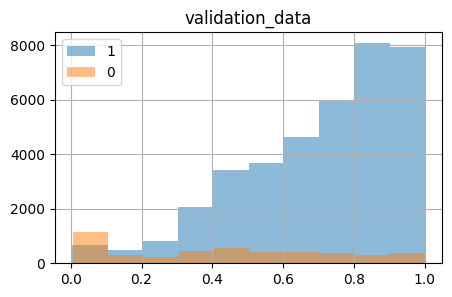

In [164]:
fig = plt.figure(figsize=(5,3))

plt.title('validation_data')
plt.hist(train_oof['pred'][np.array(y_train).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(train_oof['pred'][np.array(y_train).reshape(-1)==0], bins=10, alpha=0.5, label='0')

plt.grid()
plt.legend()

In [165]:
def predict_tabnet(input_x,
                   input_id,
               list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_tabnet = 'model/tabnet/model_tabnet_fold{}.pickle'.format(nfold)
        with open(fname_tabnet, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = model.predict_proba(input_x.values)[:,1]
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'target_label':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [166]:
# trainとtestのカラムをセットとして取得
train_columns = set(X_train.columns)
test_columns = set(x_test.columns)

# trainにのみ存在するカラムを見つける
train_unique = train_columns - test_columns

# testにのみ存在するカラムを見つける
test_unique = test_columns - train_columns

# 結果を表示
print("Train unique columns:", train_unique)
print("Test unique columns:", test_unique)

Train unique columns: set()
Test unique columns: set()


In [167]:
test_pred_proba = pd.DataFrame()

In [168]:
test_pred_proba = predict_tabnet(
        x_test,
        id_test,
        list_nfold=[0,1,2,3,4],
        )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done


In [169]:
# 'target' 列でNaNを含む行を削除
test_pred_proba = test_pred_proba.dropna(subset=['target_label'])

In [197]:
# 閾値を設定
threshold = 0.39898009

# 予測確率を0か1に変換
test_predictions = np.where(test_pred_proba['target_label'] >= threshold, 1, 0)

# 1 の割合を計算
ones_ratio = np.mean(test_predictions)

# 0 の割合を計算
zeros_ratio = 1 - ones_ratio

print(f"0 の割合: {zeros_ratio}")
print(f"1 の割合: {ones_ratio}")

0 の割合: 0.10730831048501466
1 の割合: 0.8926916895149853


In [198]:
#1の割合: 0.8926891530952324

In [199]:
test_predictions

array([0, 1, 0, ..., 1, 1, 0])

In [200]:
from datetime import datetime

# 現在の日付と時間を取得して、指定のフォーマットに変換
current_datetime = datetime.now().strftime('%Y%m%d_%H%M%S')

submit = pd.read_csv('../data/sample_submission.csv', header=None)

submit.iloc[:, 1] = test_predictions
filename = f'TabNet_Stacking_cb_lgb_{current_datetime}'

submit.to_csv('outputs/' + filename + '.csv', index=False,header=None)

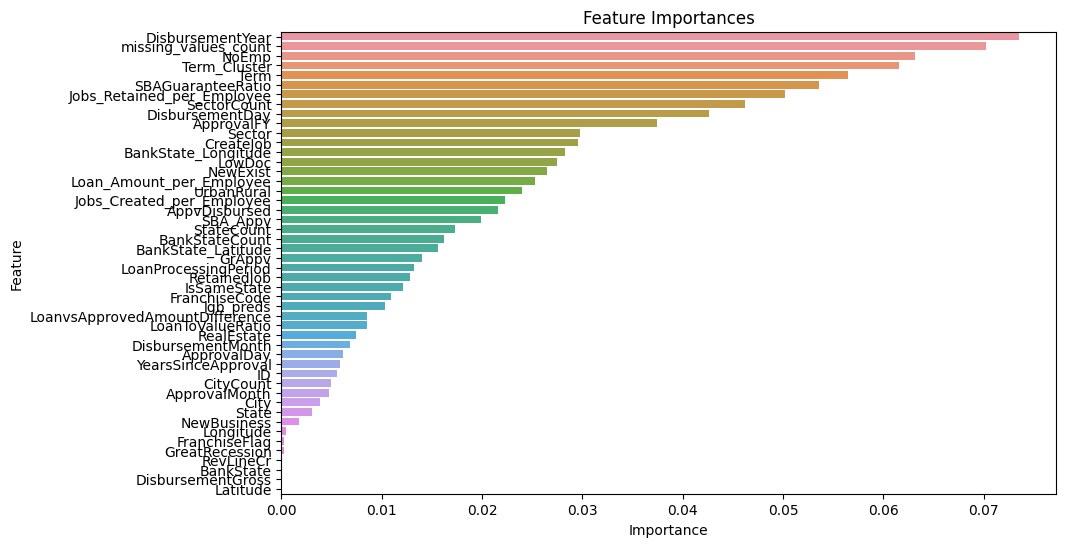

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns



fname_tabnet = 'model/tabnet/model_tabnet_fold{}.pickle'.format(0)
with open(fname_tabnet, 'rb')as f:
    model = pickle.load(f)
            
# 特徴の重要度を取得
importances = model.feature_importances_

# 特徴とその重要度を組み合わせる
features_importances = zip(all_features, importances)
features_importances = sorted(features_importances, key = lambda x: x[1], reverse=True)

# 特徴名と重要度をそれぞれのリストに分ける
sorted_features = [feature for feature, importance in features_importances]
sorted_importances = [importance for feature, importance in features_importances]

# グラフを作成
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [202]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings

print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
y_pred_binary = np.where(train_oof['pred'] > threshold, 1, 0)  # 0.5が閾値

# スコア関数の修正
score_funcs = [
    accuracy_score, 
    lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'), 
    lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary'),
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    roc_auc_score  # この関数は確率をそのまま使用
]

# スコアの計算（roc_auc_score以外はy_pred_binaryを使用）
scores = [
    round(f(y_train, y_pred_binary if f != roc_auc_score else train_oof['pred']), 3)
    for f in score_funcs
]

print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.849, 0.932, 0.896, 0.914, 0.752


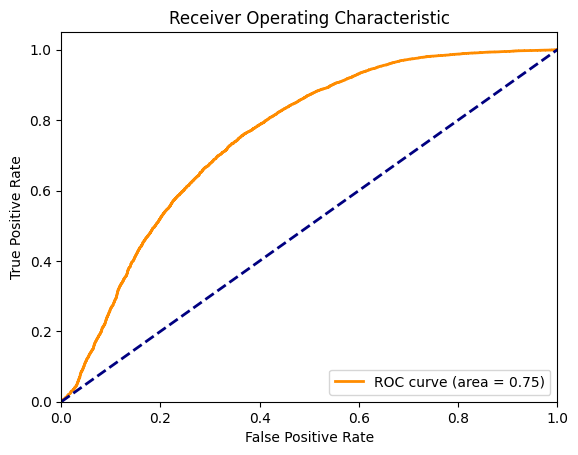

In [203]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# FPR, TPR, およびしきい値を計算する
fpr, tpr, thresholds = roc_curve(y_train, train_oof['pred'])

# AUC（Area Under Curve）を計算する
roc_auc = auc(fpr, tpr)

# ROC曲線をプロットする
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()